In [11]:
from itertools import product
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
preprocess_transforms = [
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
]

augmentation_transforms = [
    transforms.RandomRotation(45),
    v2.RandomResizedCrop(size=(28, 28), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
]

train_indices = torch.randperm(60000)[:2000]
train_dataset = torch.utils.data.Subset(torchvision.datasets.FashionMNIST(
        root='./data', train=True, download=True, 
        transform=transforms.Compose(preprocess_transforms + augmentation_transforms)
    ),
    train_indices
)

test_indices = torch.randperm(10000)[:350]
test_dataset = torch.utils.data.Subset(torchvision.datasets.FashionMNIST(
        root='./data', train=False, download=True, 
        transform=transforms.Compose(preprocess_transforms)
    ),
    test_indices
)

In [4]:
batch_sizes = [16, 32, 64]
num_epochs = [5, 10, 20]
learning_rates = [1e-3, 1e-4]
dropouts = [0.0, 0.2]

optimizers = {'SGD': optim.SGD, 'Adam': optim.Adam, 'RMSprop': optim.RMSprop}

def get_data_loader(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [5]:
def create_cnn(dropout=0.0, depth=3, h=64):
    layers = []
    width, height, dim = 28, 28, 1

    for i in range(depth):
        in_ch = 16 * (2 ** (i - 1)) if i > 0 else dim
        out_ch = 16 * (2 ** i)

        layers.append(nn.Conv2d(in_ch, out_ch, 3, padding='same'))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(3))

    if dropout > 0:
        layers.append(nn.Dropout2d(dropout))

    layers.append(nn.Flatten())
    layers.append(nn.LazyLinear(h))
    layers.append(nn.ReLU())

    layers.append(nn.Linear(h, 10))
    layers.append(nn.Softmax())
    return nn.Sequential(*layers)

In [6]:
def train_and_evaluate(batch_size, optimizer_name, lr, dropout, max_epochs=50, verbose=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_loader, test_loader = get_data_loader(batch_size)
    model = create_cnn(dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizers[optimizer_name](model.parameters(), lr=lr)

    best_acc = 0.0
    min_loss = float('inf')
    patience_counter = 0
    history = []

    for epoch in range(max_epochs):
        model.train()
        correct, total = 0, 0
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
        train_acc = correct / total
        train_loss = running_loss / len(train_loader)

        model.eval()
        correct, total = 0, 0
        running_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                running_loss += loss.item()
        test_acc = correct / total
        test_loss = running_loss / len(test_loader)

        history.append((train_acc, train_loss, test_acc, test_loss))
        if verbose:
            print(f"{epoch + 1}: Train Acc {train_acc} Train Loss {train_loss} Test Acc {test_acc} Test Loss {test_loss}")

        if test_acc > best_acc:
            best_acc = test_acc

    return best_acc, history, model

In [7]:
param_grid = product(batch_sizes, num_epochs, learning_rates, dropouts, optimizers.keys())
results = []

best_model_acc = 0
best_model = None
for batch_size, epochs, lr, dropout, optimizer_name in param_grid:
    best_acc, history, model = train_and_evaluate(batch_size, optimizer_name, lr, dropout, max_epochs=epochs)
    if best_acc > best_model_acc:
        best_model_acc = best_acc
        best_model = model
    res = (batch_size, epochs, lr, dropout, optimizer_name, best_acc, history)
    print(f"Batch: {res[0]}, Epochs: {res[1]}, Learning rate: {res[2]}, Dropout: {res[3]}, Opt: {res[4]} Acc: {res[5]:.4f}")
    results.append(res)

/home/volodymyr/.local/share/virtualenvs/python_neural_nets-VlmVW8YE/lib/python3.10/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Batch: 16, Epochs: 5, Learning rate: 0.001, Dropout: 0.0, Opt: SGD Acc: 0.1057
Batch: 16, Epochs: 5, Learning rate: 0.001, Dropout: 0.0, Opt: Adam Acc: 0.4886
Batch: 16, Epochs: 5, Learning rate: 0.001, Dropout: 0.0, Opt: RMSprop Acc: 0.4971
Batch: 16, Epochs: 5, Learning rate: 0.001, Dropout: 0.2, Opt: SGD Acc: 0.0629
Batch: 16, Epochs: 5, Learning rate: 0.001, Dropout: 0.2, Opt: Adam Acc: 0.5143
Batch: 16, Epochs: 5, Learning rate: 0.001, Dropout: 0.2, Opt: RMSprop Acc: 0.4771
Batch: 16, Epochs: 5, Learning rate: 0.0001, Dropout: 0.0, Opt: SGD Acc: 0.1114
Batch: 16, Epochs: 5, Learning rate: 0.0001, Dropout: 0.0, Opt: Adam Acc: 0.3743
Batch: 16, Epochs: 5, Learning rate: 0.0001, Dropout: 0.0, Opt: RMSprop Acc: 0.2257
Batch: 16, Epochs: 5, Learning rate: 0.0001, Dropout: 0.2, Opt: SGD Acc: 0.1143
Batch: 16, Epochs: 5, Learning rate: 0.0001, Dropout: 0.2, Opt: Adam Acc: 0.3171
Batch: 16, Epochs: 5, Learning rate: 0.0001, Dropout: 0.2, Opt: RMSprop Acc: 0.3114
Batch: 16, Epochs: 10, Lea

In [8]:
# df = pd.DataFrame(results, columns=['Batch', 'Epochs', 'Learning rate', 'Dropout', 'Opt', 'Acc', 'History'])
# df.to_csv('data/c_5_lab_2_out.csv', index=False)

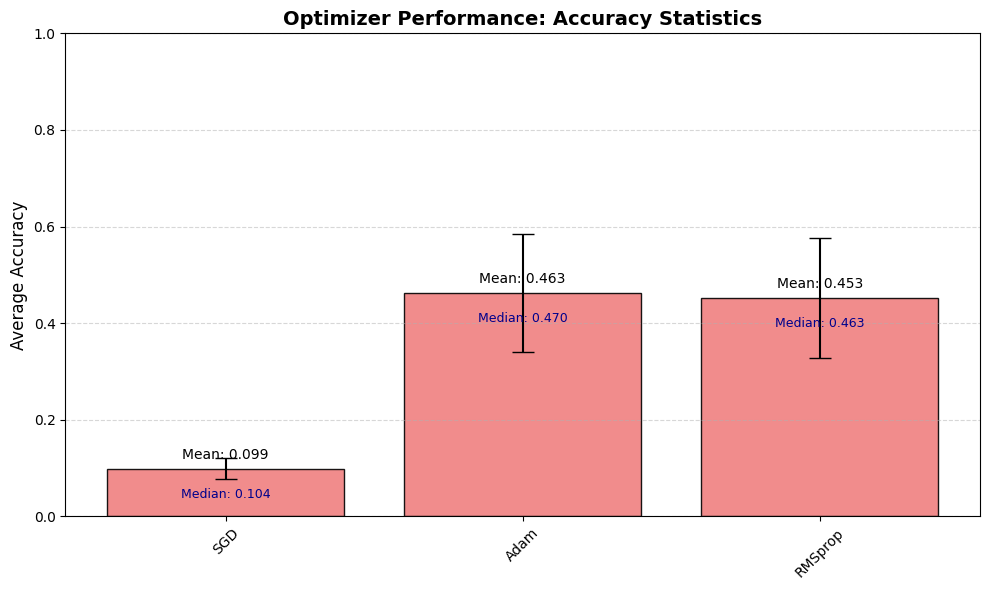

In [18]:
optimizer_scores = defaultdict(list)
for res in results:
    optimizer_name = res[4]
    best_acc = res[5]
    optimizer_scores[optimizer_name].append(best_acc)

optimizer_stats = {}
for opt, accs in optimizer_scores.items():
    optimizer_stats[opt] = {
        "mean": np.mean(accs),
        "median": np.median(accs),
        "std": np.std(accs)
    }

optimizers = list(optimizer_stats.keys())
means = [optimizer_stats[opt]["mean"] for opt in optimizers]
medians = [optimizer_stats[opt]["median"] for opt in optimizers]
stds = [optimizer_stats[opt]["std"] for opt in optimizers]

plt.figure(figsize=(10, 6))
bars = plt.bar(optimizers, means, yerr=stds, capsize=8, color='lightcoral', edgecolor='black', alpha=0.9)

for i, (mean_val, median_val) in enumerate(zip(means, medians)):
    plt.text(i, mean_val + 0.02, f"Mean: {mean_val:.3f}", ha='center', fontsize=10, color='black')
    plt.text(i, mean_val - 0.06, f"Median: {median_val:.3f}", ha='center', fontsize=9, color='darkblue')

plt.title("Optimizer Performance: Accuracy Statistics", fontsize=14, weight='bold')
plt.ylabel("Average Accuracy", fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

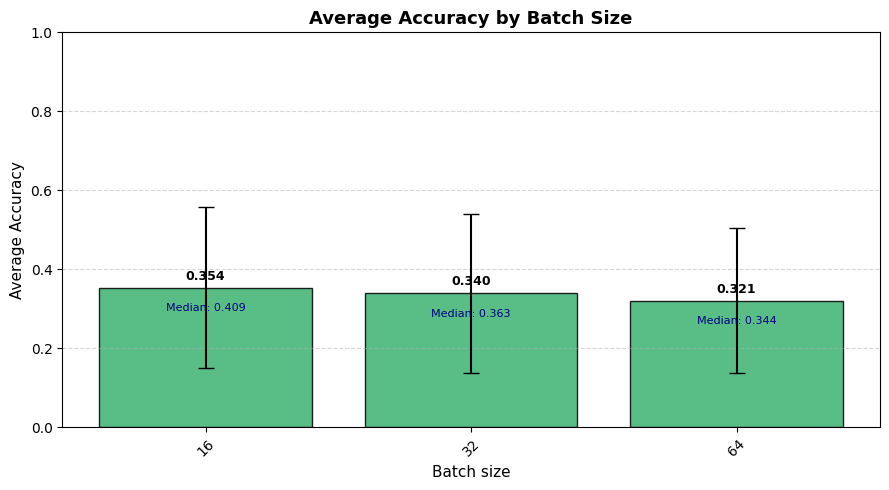

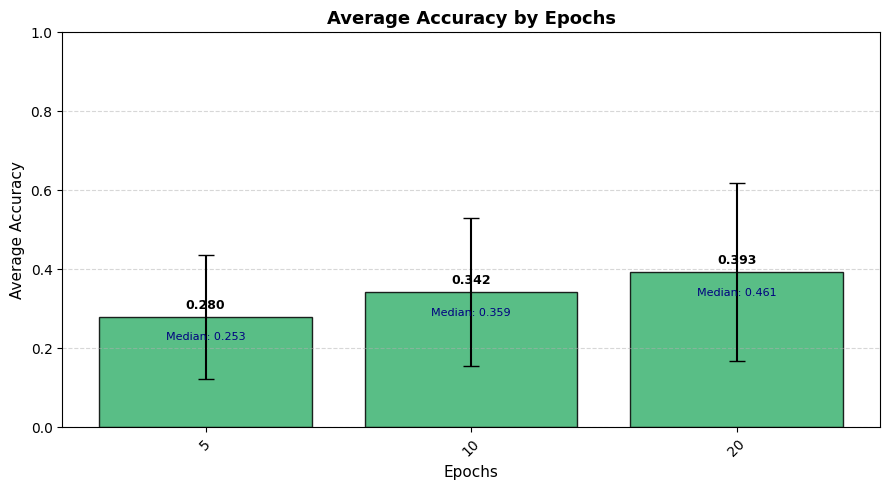

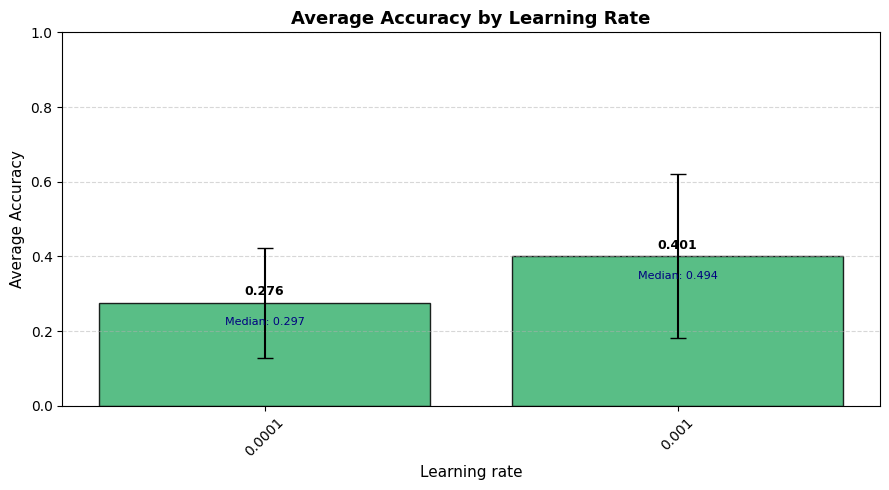

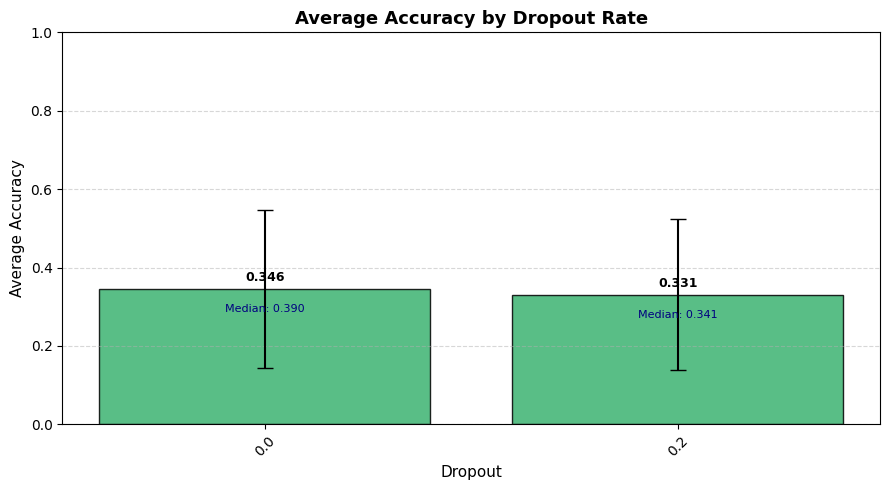

In [19]:
def plot_param_performance(param_name, index, title):
    import matplotlib.pyplot as plt
    from collections import defaultdict
    import numpy as np

    # === Aggregate stats ===
    param_scores = defaultdict(list)
    for res in results:
        key = res[index]
        acc = res[5]
        param_scores[key].append(acc)

    param_stats = {}
    for val, scores in param_scores.items():
        param_stats[val] = {
            "mean": np.mean(scores),
            "median": np.median(scores),
            "std": np.std(scores)
        }

    # Sort by param value
    sorted_items = sorted(param_stats.items(), key=lambda x: x[0])
    keys = [str(k) for k, _ in sorted_items]
    means = [v["mean"] for _, v in sorted_items]
    medians = [v["median"] for _, v in sorted_items]
    stds = [v["std"] for _, v in sorted_items]

    # === Plot ===
    plt.figure(figsize=(9, 5))
    bars = plt.bar(keys, means, yerr=stds, capsize=6, color='mediumseagreen', edgecolor='black', alpha=0.85)

    # Annotate bars
    for i, (mean_val, median_val) in enumerate(zip(means, medians)):
        plt.text(i, mean_val + 0.02, f"{mean_val:.3f}", ha='center', fontsize=9, fontweight='bold', color='black')
        plt.text(i, mean_val - 0.06, f"Median: {median_val:.3f}", ha='center', fontsize=8, color='navy')

    plt.title(title, fontsize=13, weight='bold')
    plt.xlabel(param_name.replace('_', ' ').capitalize(), fontsize=11)
    plt.ylabel("Average Accuracy", fontsize=11)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_param_performance("batch_size", 0, "Average Accuracy by Batch Size")
plot_param_performance("epochs", 1, "Average Accuracy by Epochs")
plot_param_performance("learning_rate", 2, "Average Accuracy by Learning Rate")
plot_param_performance("dropout", 3, "Average Accuracy by Dropout Rate")


Looking at the hyperparameters, we can say that the most crucial ones are epochs, optimizer type and learning rate.
Batch size and drop out have relatively equal accuracies with different values. Bigger value of the learning rate was quite important too.

In [14]:
best_result = max(results, key=lambda x: x[5])

print("Best configuration:")
print(f"Batch Size: {best_result[0]}")
print(f"Epochs: {best_result[1]}")
print(f"Learning Rate: {best_result[2]}")
print(f"Dropout: {best_result[3]}")
print(f"Optimizer: {best_result[4]}")
print(f"Accuracy: {best_result[5]:.4f}")

Best configuration:
Batch Size: 32
Epochs: 20
Learning Rate: 0.001
Dropout: 0.2
Optimizer: Adam
Accuracy: 0.6571


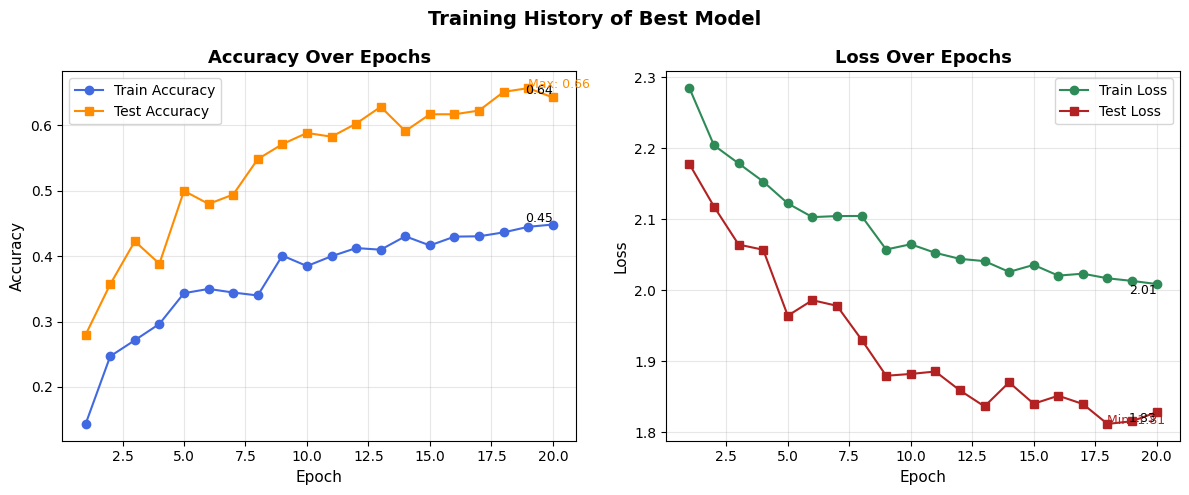

In [20]:
best_history = best_result[6]
train_accs, train_losses, test_accs, test_losses = zip(*best_history)
epochs = range(1, len(train_accs) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accs, label='Train Accuracy', marker='o', color='royalblue')
plt.plot(epochs, test_accs, label='Test Accuracy', marker='s', color='darkorange')

plt.text(epochs[-1], train_accs[-1], f"{train_accs[-1]:.2f}", ha='right', va='bottom', fontsize=9)
plt.text(epochs[-1], test_accs[-1], f"{test_accs[-1]:.2f}", ha='right', va='bottom', fontsize=9)
plt.text(np.argmax(test_accs)+1, max(test_accs), f"Max: {max(test_accs):.2f}", color='darkorange', fontsize=9)

plt.title('Accuracy Over Epochs', fontsize=13, weight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o', color='seagreen')
plt.plot(epochs, test_losses, label='Test Loss', marker='s', color='firebrick')

plt.text(epochs[-1], train_losses[-1], f"{train_losses[-1]:.2f}", ha='right', va='top', fontsize=9)
plt.text(epochs[-1], test_losses[-1], f"{test_losses[-1]:.2f}", ha='right', va='top', fontsize=9)
plt.text(np.argmin(test_losses)+1, min(test_losses), f"Min: {min(test_losses):.2f}", color='firebrick', fontsize=9)

plt.title('Loss Over Epochs', fontsize=13, weight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss', fontsize=11)
plt.legend()
plt.grid(alpha=0.3)

plt.suptitle("Training History of Best Model", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


/home/volodymyr/.local/share/virtualenvs/python_neural_nets-VlmVW8YE/lib/python3.10/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


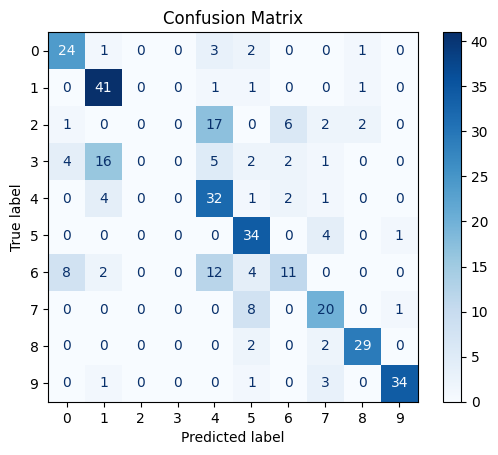

In [16]:
batch_size = best_result[0]
_, test_loader = get_data_loader(batch_size)

best_model.eval()

all_preds = []
all_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = best_model.to(device)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute and display confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

/home/volodymyr/.local/share/virtualenvs/python_neural_nets-VlmVW8YE/lib/python3.10/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


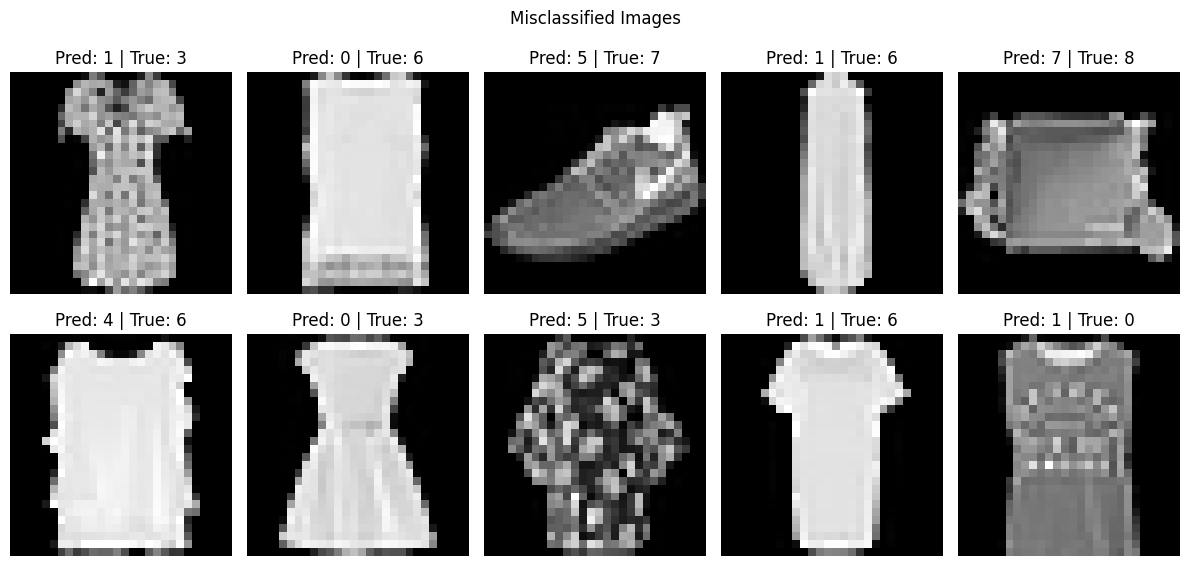

In [17]:
misclassified = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                misclassified.append((images[i].cpu(), predicted[i].item(), labels[i].item()))
            if len(misclassified) >= 10:
                break
        if len(misclassified) >= 10:
            break

plt.figure(figsize=(12, 6))
for i, (img, pred, true) in enumerate(misclassified[:10]):
    img = img.squeeze()  # For grayscale
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {pred} | True: {true}")
    plt.axis('off')
plt.suptitle("Misclassified Images")
plt.tight_layout()
plt.show()